# I-MOTION Model 

In [1]:
import time

import torch
import torch.nn as nn
import random
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Set a fixed random seed for reproducibility across multiple libraries
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
window_size = 600
# Check for CUDA (GPU support) and set device accordingly
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # For multi-GPU setups
    # Additional settings for ensuring reproducibility on CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")

CUDA is available. Using GPU.


## Load Data

In [2]:
train_data_x = np.loadtxt("/datasets/project-database/Acc_x.txt", delimiter=" ")
train_data_y = np.loadtxt("/datasets/project-database/Acc_y.txt", delimiter=" ")
train_data_z = np.loadtxt("/datasets/project-database/Acc_z.txt", delimiter=" ")
train_label = np.loadtxt("/datasets/project-database/train_label.txt", delimiter=" ")
train_order = np.loadtxt("/datasets/project-database/train_order.txt", dtype=float)
acc_data = np.dstack((train_data_x, train_data_y, train_data_z, train_label))
acc_data = acc_data[train_order.astype(np.int_).flatten() - 1, :, :]
window_data = np.empty((acc_data.shape[0] * (acc_data.shape[1]//window_size), window_size, 3), dtype=np.float32)
windowed_labels = np.empty((acc_data.shape[0] * (acc_data.shape[1]//window_size), 1), dtype=np.float32)

window_index = 0
for frame_index in range(acc_data.shape[0]):
    
    frame_features = acc_data[frame_index, :, :3]
    frame_labels = acc_data[frame_index, :, 3]
    
    for start in range(0, acc_data.shape[1], window_size):
        end = start + window_size
        window_data[window_index] = frame_features[start:end, :]
        # Assuming all samples in a window have the same label, take the label of the first sample
        windowed_labels[window_index] = frame_labels[start]
        window_index += 1
        
test_data_x = np.loadtxt("/datasets/project-database/test_Acc_x.txt", delimiter=" ")
test_data_y = np.loadtxt("/datasets/project-database/test_Acc_y.txt", delimiter=" ")
test_data_z = np.loadtxt("/datasets/project-database/test_Acc_z.txt", delimiter=" ")
test_label = np.loadtxt("/datasets/project-database/test_label.txt", delimiter=" ")
test_order = np.loadtxt("/datasets/project-database/test_order.txt", dtype=float)
acc_data = np.dstack((test_data_x, test_data_y, test_data_z, test_label))
acc_data = acc_data[test_order.astype(np.int_).flatten() - 1, :, :]
test_window_data = np.empty((acc_data.shape[0] * (acc_data.shape[1]//window_size), window_size, 3), dtype=np.float32)
test_windowed_labels = np.empty((acc_data.shape[0] * (acc_data.shape[1]//window_size), 1), dtype=np.float32)

window_index = 0
for frame_index in range(acc_data.shape[0]):
    
    frame_features = acc_data[frame_index, :, :3]
    frame_labels = acc_data[frame_index, :, 3]
    
    for start in range(0, acc_data.shape[1], window_size):
        end = start + window_size
        test_window_data[window_index] = frame_features[start:end, :]
        # Assuming all samples in a window have the same label, take the label of the first sample
        test_windowed_labels[window_index] = frame_labels[start]
        window_index += 1

# Verify the shapes
print("Train Features shape:", window_data.shape)
print("Train Labels shape:", windowed_labels.shape)
print("Test Features shape:", test_window_data.shape)
print("Test Labels shape:", test_windowed_labels.shape)
    

Train Features shape: (163100, 600, 3)
Train Labels shape: (163100, 1)
Test Features shape: (56980, 600, 3)
Test Labels shape: (56980, 1)


## Helper Function

In [3]:
def plot_training_losses(train_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.title('Training Loss Over Epochs', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()


def calculate_padding(kernel_size):
    return (kernel_size - 1) // 2

def calculate_output_length(input_length, kernel_size, stride, padding):
    return ((input_length + 2 * padding - kernel_size) // stride) + 1

def calculate_pooling_padding(window_size, stride, input_size, output_size):
    return ((output_size - 1) * stride - input_size + window_size) // 2

## Preprocessing

In [4]:
import time
from scipy.signal import butter, filtfilt
def preprocess_accelerometer_data(accel_data, m=5, cutoff=0.1, fs=100, order=5):
    # Initialize gravity and linear acceleration
    
    # Step 1: Remove Gravity
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    linear_acceleration = filtfilt(b, a, accel_data, axis=0)
    
    # Step 2: Smooth Data
    # Create a moving average (MA) filter
    window = np.ones(m) / m
    # Apply the moving average filter to each column
    smoothed_data = np.zeros_like(linear_acceleration)
    for i in range(linear_acceleration.shape[1]):
        smoothed_data[:, i] = np.convolve(linear_acceleration[:, i], window, mode='same')

    # Step 3: Calculate Magnitude
    magnitudes = np.sqrt(np.sum(smoothed_data**2, axis=1))
    return magnitudes


# window_data size is 163100 x 600 x 3.
train_processed_data = np.array([preprocess_accelerometer_data(window_data[i, :, :]) for i in range(window_data.shape[0])])
test_processed_data = np.array([preprocess_accelerometer_data(test_window_data[i, :, :]) for i in range(test_window_data.shape[0])])
print(train_processed_data.shape)  # Output the shape of the processed data
print(test_processed_data.shape)

(163100, 600)
(56980, 600)


In [5]:
"""
for k in range(1, K + 1):  # k is 1-indexed in the mathematical formula
        if k <= m // 2:
            # Early data points: smaller window size that grows
            smoothed_data[k - 1, :] = np.sum(linear_acceleration[:2 * k - 1, :], axis=0) / (2 * k - 1)
        elif k > K - m // 2:
            # Late data points: smaller window size that shrinks
            smoothed_data[k - 1, :] = np.sum(linear_acceleration[2 * k - K - 1:, :]) / (2 * (K - k) + 1)
        else:
            # Middle data points: fixed window size
            smoothed_data[k - 1, :] = np.sum(linear_acceleration[k - m // 2 - 1 : k + m // 2, :]) / m
"""

'\nfor k in range(1, K + 1):  # k is 1-indexed in the mathematical formula\n        if k <= m // 2:\n            # Early data points: smaller window size that grows\n            smoothed_data[k - 1, :] = np.sum(linear_acceleration[:2 * k - 1, :], axis=0) / (2 * k - 1)\n        elif k > K - m // 2:\n            # Late data points: smaller window size that shrinks\n            smoothed_data[k - 1, :] = np.sum(linear_acceleration[2 * k - K - 1:, :]) / (2 * (K - k) + 1)\n        else:\n            # Middle data points: fixed window size\n            smoothed_data[k - 1, :] = np.sum(linear_acceleration[k - m // 2 - 1 : k + m // 2, :]) / m\n'

## Model Construction

In [6]:
class IMOTION_CNN(nn.Module):
    def __init__(self, in_feature=600, in_channel=1, out_feature=8, pool_window_size=4, pool_stride_size=2, 
                 pool_padding=1, conv_filter_list=[32, 64, 64, 64, 64, 64], conv_kernel_list=[15, 10, 10, 5, 5, 5], conv_stride=1, full_connection_size=200):
        super(IMOTION_CNN, self).__init__()
        self.pool = nn.MaxPool1d(kernel_size=pool_window_size, stride=pool_stride_size, padding=pool_padding)
        assert len(conv_filter_list) == len(conv_kernel_list)
        self.conv_layers = nn.ModuleList([
            nn.Conv1d(in_channels=in_channel if i == 0 else conv_filter_list[i-1], 
                      out_channels=conv_filter_list[i], 
                      kernel_size=conv_kernel_list[i], stride=conv_stride, padding=calculate_padding(conv_kernel_list[i]))
            for i in range(len(conv_filter_list))
        ])
        self.final_matrix_size = conv_filter_list[-1] * (in_feature // (2 ** (len(conv_filter_list))))
        self.fc1 = nn.Linear(self.final_matrix_size, full_connection_size) 
        self.fc2 = nn.Linear(full_connection_size, out_feature)


    def forward(self, x):
        for conv in self.conv_layers:
            x = self.pool(torch.relu(conv(x)))
        x = x.view(x.shape[0], -1)  # Flattening the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Dataset

In [7]:
# Define a custom Dataset
class AccDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)  # Convert features to PyTorch tensors
        self.labels = torch.tensor(labels, dtype=torch.long) - 1       # Convert labels to PyTorch tensors
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

def prepare_data_loaders(train_features, train_labels, test_features, test_labels, batch_size=10):

    train_dataset = AccDataset(train_features, train_labels)
    test_dataset = AccDataset(test_features, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

## Training & Evaluation

In [10]:
def train_model(model, train_loader, optimizer, criterion, epochs=100, device='cpu'):
    model.train()  # Set the model to training mode
    loss_values = []  # Initialize a list to store the average loss per epoch

    for epoch in range(epochs):
        total_loss = 0  # Track total loss for each epoch
        for X, labels in train_loader:
            # Move data to the specified device
            X, labels = X.to(device), labels.to(device)
            X = X.unsqueeze(1)
            optimizer.zero_grad()  # Clear gradients for the next train step
            output = model(X)  # Forward pass
            labels = labels.squeeze(1) 
            loss = criterion(output, labels)  # Compute the loss
            loss.backward()  # Backward pass to compute gradients
            optimizer.step()  # Update model parameters
            total_loss += loss.item()  # Accumulate the loss
        avg_loss = total_loss / len(train_loader)  # Calculate average loss
        loss_values.append(avg_loss)  # Append average loss to list

        # Print the average loss for the current epoch
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

    return loss_values


def evaluate_model(model, test_loader, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    true_labels = []  # List to store actual labels
    predictions = []  # List to store model predictions

    with torch.no_grad():  # Disable gradient computation
        for X, labels in test_loader:
            # Move data to the specified device
            X, labels = X.to(device), labels.to(device)
            X = X.unsqueeze(1)
            output = model(X)  # Forward pass
            _, predicted = torch.max(output.data, 1)  # Get the index of the max log-probability
            labels = labels.squeeze(1) 
            true_labels += labels.tolist()  # Append actual labels
            predictions += predicted.tolist()  # Append predicted labels

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')
    cm = confusion_matrix(true_labels, predictions)
    

    return accuracy, precision, recall, f1, cm

## Main Script


Training model
DataLoader batch size: 100
Epoch 1/200, Loss: 1.0000
Epoch 2/200, Loss: 0.7920
Epoch 3/200, Loss: 0.7441
Epoch 4/200, Loss: 0.7151
Epoch 5/200, Loss: 0.6881
Epoch 6/200, Loss: 0.6745
Epoch 7/200, Loss: 0.6593
Epoch 8/200, Loss: 0.6479
Epoch 9/200, Loss: 0.6358
Epoch 10/200, Loss: 0.6246
Epoch 11/200, Loss: 0.6147
Epoch 12/200, Loss: 0.6070
Epoch 13/200, Loss: 0.5983
Epoch 14/200, Loss: 0.5895
Epoch 15/200, Loss: 0.5800
Epoch 16/200, Loss: 0.5765
Epoch 17/200, Loss: 0.5672
Epoch 18/200, Loss: 0.5615
Epoch 19/200, Loss: 0.5559
Epoch 20/200, Loss: 0.5509
Epoch 21/200, Loss: 0.5436
Epoch 22/200, Loss: 0.5405
Epoch 23/200, Loss: 0.5323
Epoch 24/200, Loss: 0.5288
Epoch 25/200, Loss: 0.5244
Epoch 26/200, Loss: 0.5181
Epoch 27/200, Loss: 0.5163
Epoch 28/200, Loss: 0.5053
Epoch 29/200, Loss: 0.5033
Epoch 30/200, Loss: 0.4966
Epoch 31/200, Loss: 0.4925
Epoch 32/200, Loss: 0.4918
Epoch 33/200, Loss: 0.4877
Epoch 34/200, Loss: 0.4806
Epoch 35/200, Loss: 0.4730
Epoch 36/200, Loss: 0

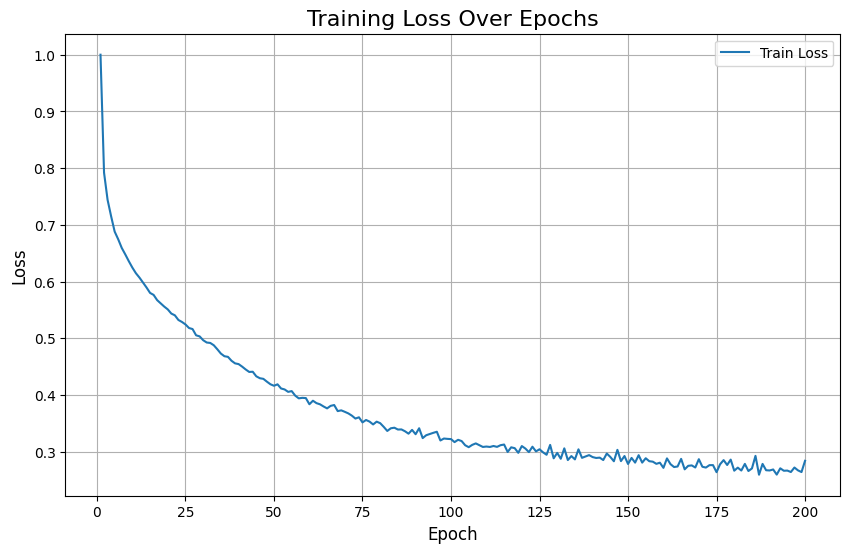

In [12]:
def main():
    """
    Main execution function to train and evaluate Graph Convolutional Network (GCN) models
    with different graph normalization techniques, visualize training metrics, and perform
    embedding analysis through PCA.

    Assumes the presence of a GCN model class, data loader preparation functions, and
    various normalization technique functions defined outside this script.
    """
    # Configuration parameters
    num_epochs = 200  # Number of training epochs
    # Dictionary mapping normalization technique names to their corresponding functions

    # Lists for storing evaluation metrics and model information
    metric_values = [[] for _ in range(4)]  # Lists to store Accuracy, Precision, Recall, F1 Score
    train_losses = []  # Training loss values for each normalization technique

    # Set the computation device (GPU or CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"\nTraining model")
    # Prepare data loaders
    train_loader, test_loader = prepare_data_loaders(train_processed_data, windowed_labels, test_processed_data, test_windowed_labels, batch_size=100)
    print(f"DataLoader batch size: {train_loader.batch_size}")

    # Initialize the GCN model, optimizer, and loss criterion
    model = IMOTION_CNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    # Train the model
    train_losses = train_model(model, train_loader, optimizer, criterion, epochs=num_epochs, device=device)
    
    model.eval()
    scripted_model = torch.jit.script(model)
    scripted_model.save("mode_prediction.pt")
    
    # Evaluate the model's performance
    accuracy, precision, recall, f1, cm = evaluate_model(model, test_loader, device=device)
    # Store the evaluation metrics
    metric_values[0].append(accuracy)
    metric_values[1].append(precision)
    metric_values[2].append(recall)
    metric_values[3].append(f1)

    # Output the evaluation results
    print(f"Results  - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print("Confusion Matrix:\n", cm)

    # Visualization of training losses and evaluation metrics for each normalization technique
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    plot_training_losses(train_losses)
    

if __name__ == "__main__":
    main()


In [5]:
import numpy as np
import pandas as pd

# Original confusion matrix
conf_matrix = np.array([
    [7031, 129, 2, 107, 240, 146, 888, 1103],
    [130, 6708, 19, 141, 33, 36, 67, 137],
    [4, 71, 3234, 61, 0, 5, 2, 3],
    [48, 117, 10, 4748, 67, 63, 33, 38],
    [88, 9, 2, 32, 10068, 1988, 207, 375],
    [163, 73, 3, 106, 1780, 5820, 383, 656],
    [801, 90, 1, 48, 747, 636, 2639, 1519],
    [636, 27, 1, 19, 185, 140, 926, 1391]
])

# Convert to percentages
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

# Convert matrices to DataFrames for better readability
conf_matrix_df = pd.DataFrame(conf_matrix_percent, columns=[f'Class {i}' for i in range(1, 9)])

# Display DataFrames
print("Original Confusion Matrix Percentages:")
display(conf_matrix_df)

# Combine last two columns
conf_matrix_reduced_cols = np.hstack((conf_matrix[:, :-2], conf_matrix[:, -2:].sum(axis=1, keepdims=True)))

# Combine last two rows of the newly adjusted matrix
conf_matrix_reduced = np.vstack((conf_matrix_reduced_cols[:-2], conf_matrix_reduced_cols[-2:].sum(axis=0, keepdims=True)))

# Convert the new matrix to percentages
conf_matrix_percent = conf_matrix_reduced / conf_matrix_reduced.sum(axis=1, keepdims=True) * 100

# Convert to DataFrame for better readability
conf_matrix_df = pd.DataFrame(conf_matrix_percent, columns=[f'Class {i}' for i in range(1, 8)])

# Display DataFrame
print("Combined Class 7 and 8 Confusion Matrix Percentages:")
display(conf_matrix_df)


Original Confusion Matrix Percentages:


,Class 1,Class 2,Class 3,Class 4,Class 5,Class 6,Class 7,Class 8
0,72.890317,1.337342,0.020734,1.109268,2.488078,1.513581,9.205888,11.434792
1,1.787925,92.256911,0.261312,1.939211,0.453858,0.495118,0.921469,1.884197
2,0.118343,2.100592,95.680473,1.804734,0.000000,0.147929,0.059172,0.088757
3,0.936768,2.283372,0.195160,92.661983,1.307572,1.229508,0.644028,0.741608
4,0.689169,0.070483,0.015663,0.250607,78.847208,15.568956,1.621114,2.936800
5,1.814337,0.812556,0.033393,1.179875,19.813001,64.781834,4.263134,7.301870
6,12.359204,1.388675,0.015430,0.740626,11.525999,9.813300,40.719025,23.437741
7,19.127820,0.812030,0.030075,0.571429,5.563910,4.210526,27.849624,41.834586


Combined Class 7 and 8 Confusion Matrix Percentages:


,Class 1,Class 2,Class 3,Class 4,Class 5,Class 6,Class 7
0,72.890317,1.337342,0.020734,1.109268,2.488078,1.513581,20.640680
1,1.787925,92.256911,0.261312,1.939211,0.453858,0.495118,2.805666
2,0.118343,2.100592,95.680473,1.804734,0.000000,0.147929,0.147929
3,0.936768,2.283372,0.195160,92.661983,1.307572,1.229508,1.385636
4,0.689169,0.070483,0.015663,0.250607,78.847208,15.568956,4.557914
5,1.814337,0.812556,0.033393,1.179875,19.813001,64.781834,11.565004
6,14.654293,1.193147,0.020396,0.683255,9.504385,7.913522,66.031001


In [8]:
conf_matrix = np.array([
    [7031, 129, 2, 107, 240, 146, 1991],
    [130, 6708, 19, 141, 33, 36, 204],
    [4, 71, 3234, 61, 0, 5, 5],
    [48, 117, 10, 4748, 67, 63, 71],
    [88, 9, 2, 32, 10068, 1988, 582],
    [163, 73, 3, 106, 1780, 5820, 1039],
    [1437, 117, 2, 67, 932, 776, 3910]
])

# Calculate accuracy
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)

# Calculate precision, recall, and F1 score for each class
precision = []
recall = []
f1_score = []

for i in range(conf_matrix.shape[1]):
    tp = conf_matrix[i, i]
    fp = conf_matrix[:, i].sum() - tp
    fn = conf_matrix[i, :].sum() - tp
    prec = tp / (tp + fp) if (tp + fp) != 0 else 0
    rec = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * prec * rec / (prec + rec) if (prec + rec) != 0 else 0
    precision.append(prec)
    recall.append(rec)
    f1_score.append(f1)

# Calculate average precision, recall, and F1 score
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1_score = np.mean(f1_score)

# Print results
print("Average Accuracy: {:.2f}%".format(accuracy * 100))
print("Average Precision: {:.2f}%".format(avg_precision * 100))
print("Average Recall: {:.2f}%".format(avg_recall * 100))
print("Average F1 Score: {:.2f}%".format(avg_f1_score * 100))

Average Accuracy: 76.30%
Average Precision: 79.09%
Average Recall: 78.73%
Average F1 Score: 78.88%


In [1]:
print(f"Results  - Accuracy: 76.30%, Precision: 79.09%, Recall: 78.73%, F1 Score: 78.88%")

Results  - Accuracy: 76.30%, Precision: 79.09%, Recall: 78.73%, F1 Score: 78.88%
